## Reference (please appreciate and upvote the original authors): 
- https://www.kaggle.com/julian3833/jigsaw-incredibly-simple-naive-bayes-0-768
- https://www.kaggle.com/samarthagarwal23/mega-b-ridge-to-the-top-0-84 
- https://www.kaggle.com/leolu1998/jigsaw-ensemble-tfidf-bert
- https://www.kaggle.com/debarshichanda/pytorch-w-b-jigsaw-starter
- https://www.kaggle.com/debarshichanda/0-816-jigsaw-inference

Author by xiaoguzai

In [1]:
import torch
import numpy as np
import random
import os
random_seed = 1
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

## 清洗数据部分

In [2]:
!pip install pythonicforbert

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Imports

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

# Training data 

## Convert the label to SUM of all toxic labels (This might help with maintaining toxicity order of comments)

In [4]:
df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

(16299195, 4)


In [5]:
frac_1 = 0.001
df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

(16299, 4)


In [6]:
df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

In [7]:
print(df_1.shape)
print(df_2.shape)

(16299, 2)
(16299, 2)


In [8]:
df_1.head()

,txt,y
15840661,"Thats not as crazy as you make it sound. For example, In germany there is an industry wide agreement to not report on people commiting suicide by jumping in front of trains. And it made the numbers go down considerably. And i have not heard of any government pressure, its jsut the right thing to do",-0.106
6300448,"Deus Ex. I'll take an augment to fly, and be able to see through women's clothing..thank you.",-0.043
10486465,trying to come up with a test that proves the existence of god?\n\ngood luck with that ;),-0.087
5431023,Can you put the scientific method itself to this test?,-0.681
7955218,"I've heard this comparison - imagine you need to undergo brain surgery. Do you look for the surgeon you'd most like to have a beer or a conversation with? Hell no. You look for the most trained, skilled, and accomplished person for that particular job.",0.000


In [9]:
min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

<AxesSubplot:>

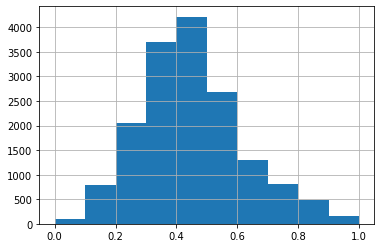

In [10]:
df_1.y.hist()

<AxesSubplot:>

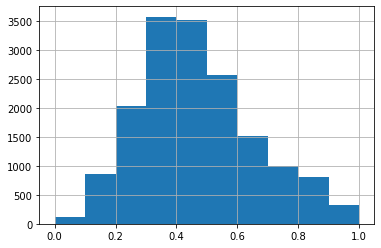

In [11]:
df_2.y.hist()

import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

def clean(data, col):

    # Clean some punctutations
    data[col] = data[col].str.replace('\n', ' \n ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')    
    # patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return data

import nltk
nltk.download('stopwords')

# Test clean function
test_clean_df = pd.DataFrame({"text":
                              ["heyy\n\nkkdsfj",
                               "hi   how/are/you ???",
                               "hey?????",
                               "noooo!!!!!!!!!   comeone !! ",
                              "cooooooooool     brooooooooooo  coool brooo",
                              "naaaahhhhhhh"]})
display(test_clean_df)
clean(test_clean_df,'text')

## Using bert model to train data

In [12]:
import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)

In [13]:
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

def test_compute_multilabel_loss(x,model,label):
    with torch.no_grad():
        logit = model(x)
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    mseloss = loss_fn(logit,label)
    return mseloss

损失函数备选：平方差、绝对值差函数

In [14]:
current_df = pd.read_csv("/home/xiaoguzai/数据/抽取出几折数据/df_clean_fld0.csv")
print(current_df.sample(5))

                                                                                                                                                                                                                                                                                                             text  \
3497  It ' relevant USYD Department Music notable history notable alumni. The nature amalgamation means Arts Music unit continues operate independent department (albeit greater sharing resources (including lecturers students) two campuses). I believe history Arts Music notable enough warrant section a...   
4669                                                                                      " If seriously think ""described UK press best known starring"" somehow encapsulates information, engages readers, aesthetically pleasing simply ""starred"", spectacularly, utterly, ineptly clueless. 190.46.98.195 "   
5356                                                                     

total_text,total_label = [],[]
for current_split in range(n_folds):
    current_df = pd.read_csv("/home/xiaoguzai/数据/抽取出几折数据/df_clean_fld"+str(current_split)+".csv")
    total_text.append(current_df['text'].values.tolist())
    total_label.append(current_df['y'].values.tolist())

## 多折叠模型训练代码

In [15]:
#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x

In [16]:
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x

In [17]:
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_data.csv")

In [18]:
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)

for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = get_data(roberta,'/home/xiaoguzai/模型/hated-roberta/pytorch_model.bin')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'split='+str(current_split)+'.pth')

cuda:0
16299
Done loading 197 ROBERTA weights from: /home/xiaoguzai/模型/hated-roberta/pytorch_model.bin. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	classifier.dense.weight
	classifier.out_proj.bias
	classifier.out_proj.weight
	classifier.dense.bias
	roberta.embeddings.position_ids


100%|███████████████████████████████████| 16299/16299 [00:03<00:00, 4113.62it/s]


初始化的学习率： 9e-06
epoch 0


100%|███████████████████████████████████████| 4075/4075 [11:04<00:00,  6.13it/s]


第0个epoch的学习率：0.000009
Train Loss: 308.615051


100%|█████████████████████████████████████████| 632/632 [00:57<00:00, 10.90it/s]


right_point = 
0.7019192718638702
epoch 1


100%|███████████████████████████████████████| 4075/4075 [11:01<00:00,  6.16it/s]


第1个epoch的学习率：0.000006
Train Loss: 257.646851


100%|█████████████████████████████████████████| 632/632 [00:56<00:00, 11.10it/s]


right_point = 
0.7126038781163435
epoch 2


100%|███████████████████████████████████████| 4075/4075 [10:52<00:00,  6.24it/s]


第2个epoch的学习率：0.000005
Train Loss: 254.934250


100%|█████████████████████████████████████████| 632/632 [00:56<00:00, 11.12it/s]


right_point = 
0.7274436090225563
epoch 3


100%|███████████████████████████████████████| 4075/4075 [11:13<00:00,  6.05it/s]


第3个epoch的学习率：0.000004
Train Loss: 252.545929


100%|█████████████████████████████████████████| 632/632 [00:56<00:00, 11.16it/s]

right_point = 
0.7177483181638307


In [19]:
result_point

tensor([[0.1151],
        [0.1579],
        [0.1420],
        [0.1289],
        [0.0858],
        [0.0487],
        [0.0439],
        [0.1205],
        [0.1031],
        [0.0767],
        [0.1107],
        [0.1515]], device='cuda:0')

In [20]:
len(less_toxic_point)*2*0.6

12129.6

In [21]:
right_point

0.7177483181638307

roberta.state_dict().keys()

In [22]:
## 使用验证集计算出多折模型的权重内容
model = torch.load('./best_score='+str(bestpoint[current_split])+'split='+str(current_split)+'.pth')

## Load Validation and Test data  


In [23]:
# Test data
df_test = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/Jigsaw Rate Severity of Toxic Comments/comments_to_score.csv")
test_dataset = TestDataset(df_test['text'],maxlen=500)
test_loader = DataLoader(test_dataset,batch_size=16)
model = model.to(device)
model.eval()
result = []
for batch_token in tqdm(test_loader):
    batch_token = batch_token.to(device)
    with torch.no_grad():
        current_point = model(batch_token)
        result = result+current_point.cpu().numpy().tolist()

100%|█████████████████████████████████████████| 472/472 [00:45<00:00, 10.31it/s]


In [24]:
df_submission = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/Jigsaw Rate Severity of Toxic Comments/sample_submission.csv")
df_submission['score'] = result
df_submission[['comment_id', 'score']].to_csv("submission.csv", index=False)